In [1]:
import os
import glob

import numpy as np
from scipy.io import wavfile

import matplotlib.pyplot as plt

import IPython.display as ipd
import IPython
import matplotlib.colors as colors

from scipy import signal
from copy import deepcopy

## Download data

In [2]:
import urllib.request
import tarfile


def download_and_extract_data(url):
    ftpstream = urllib.request.urlopen(url)
    thetarfile = tarfile.open(fileobj=ftpstream, mode="r|gz")
    thetarfile.extractall()
    
dataurl = 'http://www.openslr.org/resources/1/waves_yesno.tar.gz'
download_and_extract_data(dataurl)
path_to_sound_data = './waves_yesno/'

In [3]:
### STFT properties

nperseg = 512
window_size = 5

In [4]:
fft_sample = 50000

In [5]:
noise_std_array = [1e-1];

ini = 34500-1
end = 37500+1
ini2 = 34875
end2 = 35025

# ini2 = 33975-20
# end2 = 34025+20

### Creating Dataset

In [6]:
n_val = 5
files_source = glob.glob(os.path.join(path_to_sound_data, '*.wav'))
files_source = np.sort(files_source)
list_val_images = files_source[-n_val:]
list_train_images = list( set(files_source) - set(list_val_images));

In [7]:
fs, data = wavfile.read(list_train_images[0])

In [8]:
def perform_stft_and_inverse(source, nperseg, fs):
    source_stft = signal.stft(source, fs = fs, nperseg=nperseg);
    _, source_istft =  signal.istft(source_stft[2], fs=fs, nperseg=nperseg);
    return np.real(source_istft)

In [9]:
def get_sound_array(file_path_array, nperseg, fixed_max = None):
    sound_array = [None]*len(file_path_array);
    fs_array = [None]*len(file_path_array);
    max_array = [None]*len(file_path_array);
    for i, x in enumerate(file_path_array):
        fs, data = wavfile.read(x);
        sound_array[i] = perform_stft_and_inverse( data.astype(float), nperseg, fs);
        
        if fixed_max is None:
            max_array[i] = np.max(np.abs(sound_array[i]))
        else:
            max_array[i] = fixed_max;
        
        sound_array[i] = sound_array[i]/max_array[i]
        
#         max_array[i] = 1
        fs_array[i] = fs
    return sound_array, fs_array, max_array

In [10]:
train_dataset, train_fs_array, train_max_array = get_sound_array(list_train_images, nperseg)
val_dataset, val_fs_array, val_max_array = get_sound_array(list_val_images, nperseg)

In [11]:
max_n, min_n = 0, np.inf;
for x in train_dataset+val_dataset:
    max_n = np.maximum(max_n, len(x))
    min_n = np.minimum(min_n, len(x))
# fft_sample = max_n;
print('Max : ', max_n)
print('Min: ', min_n)

Max :  56064
Min:  39680.0


## Sound Statistics

In [12]:
def find_expected_coeff_square(train_dataset, fft_sample):
    n = len(train_dataset)
    abs_coeff_mat = 0;
    
    for i in range(n):
        temp = np.fft.fftshift( np.fft.fft(train_dataset[i], n = fft_sample ) )
        abs_coeff_mat += (np.absolute(temp) ** 2)
    
    abs_coeff_mat /= n
    
    return abs_coeff_mat

In [13]:
mean_coeff_sq = find_expected_coeff_square(train_dataset, fft_sample=fft_sample)

Text(0.5, 1.0, '$log_{10}E[X^2]$')

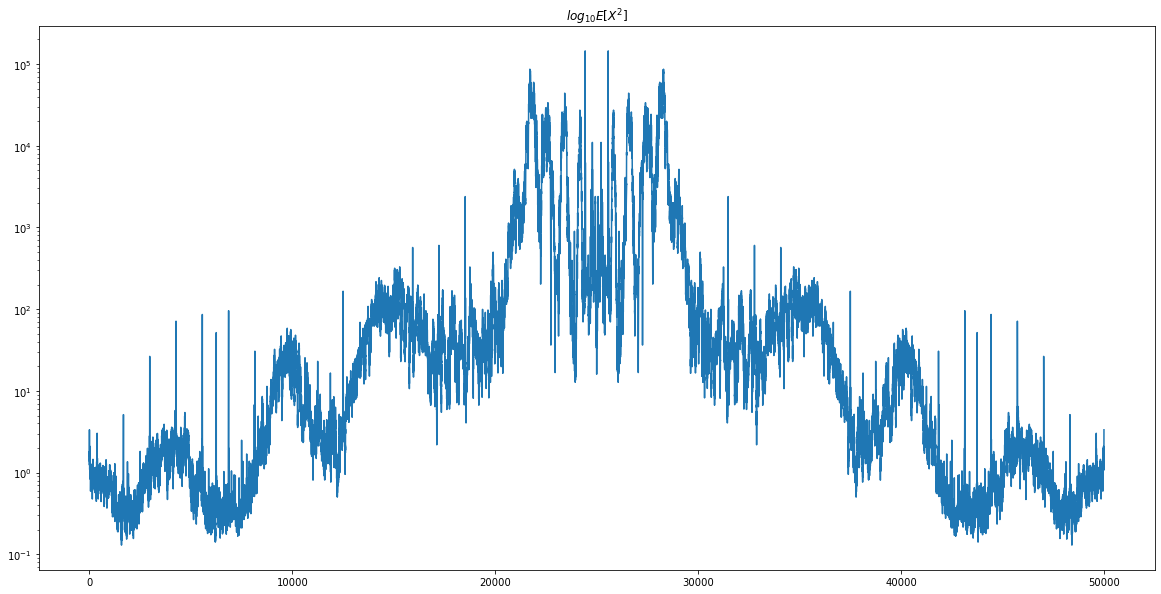

In [14]:
plt.figure(figsize = (20, 10))
plt.semilogy(mean_coeff_sq)
plt.title('$log_{10}E[X^2]$')

### Get Noise Function 

In [15]:
def get_noise(data, noise_std = 0.1, mode='S', max_noise = 5e-1):
    noise = np.random.randn(*data.shape);
    if mode == 'B':
        n = noise.shape[0];
        noise_tensor_array = max_noise * np.random.random(n);
        for i in range(n):
            noise.data[i] = noise.data[i] * noise_tensor_array[i];
    else:
        noise = noise * noise_std;
    return noise

### Theoretical Filter

In [16]:
def theoretical_wiener_from_data(train_dataset, fft_sample, noise_std, fft_shift = True, n = 25):

    mean_coeff = np.fft.fft(train_dataset[0], n = fft_sample) * 0;

    
    for i in range(n):
        for x in train_dataset:
            noisy = x + get_noise(x, noise_std=noise_std);
            noise_fft =  np.fft.fft(noisy, n = fft_sample );
            clean_fft =  np.fft.fft(x, n = fft_sample );

            mean_coeff += clean_fft * np.conjugate(noise_fft) / np.abs(noise_fft)**2

    mean_coeff /= n*len(train_dataset)
    
    if fft_shift:
        return np.fft.fftshift(mean_coeff)
    return mean_coeff

In [17]:
def theoretical_wiener_from_expected_coeff_sq(mean_coeff_sq, noise_std, n):
    return mean_coeff_sq/( mean_coeff_sq +  (n*noise_std)**2 )

In [18]:
def plot_filter_and_fft_from_fft(fft_mat, s= 17):
    fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20, 5));
    
    axes[0].set_title('Filter');
    axes[1].set_title('$log_{10}(FFT)$');
    
    filter_np = np.real( np.fft.ifft( np.fft.ifftshift(fft_mat), n = s ) );
   
    axes[0].plot(filter_np)
    
    axes[1].semilogy(fft_mat)


noise level:  0.1


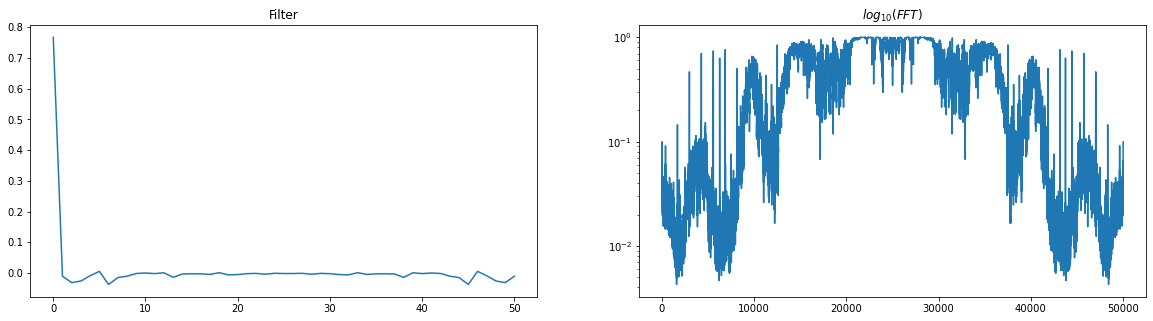

In [19]:
s = 51
wiener_star = {}
for noise_std in noise_std_array:
    print('noise level: ', noise_std)
#     wiener_star[noise_std] = theoretical_wiener_from_data(train_dataset, fft_sample, noise_std)
    wiener_star[noise_std] = theoretical_wiener_from_expected_coeff_sq(mean_coeff_sq, noise_std, len(train_dataset));
    plot_filter_and_fft_from_fft(wiener_star[noise_std], s = s)
    plt.show()

### Theoretical Wiener Denoising Example

In [20]:
def get_squared_error(vec1, vec2):
    vec1 = np.real(vec1);
    vec2 = np.real(vec2);
    return np.mean( np.square(vec1-vec2) );


In [21]:
def visualize_best_wiener_denoising(source, noise_std, wiener_star, fs, max_val, fig_size = (20, 6), fft_sample = 1000, noise_sample = None,ind_fig=0):
    
    font_size = 18
    label_size=18
    if noise_sample is None:
        noisy = source + get_noise(source, noise_std=noise_std)
    else:
        noisy = source + noise_sample;
    
    inverse_n = fft_sample;
#     inverse_n = len(source);
    
    source_fft = np.fft.fftshift(np.fft.fft(source, n = fft_sample));
    noisy_fft = np.fft.fftshift(np.fft.fft(noisy, n = fft_sample))
    denoised_fft = noisy_fft * wiener_star;
    
    source_ifft = np.fft.ifft( np.fft.ifftshift(source_fft), n = inverse_n) * max_val;
    noisy_ifft = np.fft.ifft( np.fft.ifftshift(noisy_fft), n = inverse_n) * max_val;
    denoised_ifft = np.fft.ifft( np.fft.ifftshift(denoised_fft), n = inverse_n) * max_val;
    
    t_indices = np.arange(len(source_ifft))/fs
    
    plt.figure(figsize = fig_size)
    plt.plot(np.real(source_ifft))
    plt.xlabel('Time (s)',fontsize=font_size)
    plt.tick_params(labelsize=label_size)
    
    plt.figure(figsize = fig_size)
    plt.plot(t_indices[ini:end],np.real(source_ifft[ini:end]))
    plt.xlabel('Time (s)',fontsize=font_size)
    plt.tick_params(labelsize=label_size)

    
    plt.figure(figsize = fig_size)
    plt.plot(t_indices[ini:end],np.real(noisy_ifft[ini:end]))
    plt.xlabel('Time (s)',fontsize=font_size)
    plt.tick_params(labelsize=label_size)

    
    plt.figure(figsize = fig_size)
    plt.plot(t_indices[ini:end],np.real(denoised_ifft[ini:end]))
    plt.xlabel('Time (s)',fontsize=font_size)
    plt.tick_params(labelsize=label_size)

   
    plt.figure(figsize = fig_size)
    plt.plot(t_indices[ini2:end2],np.real(source_ifft[ini2:end2]),'--o',markersize=6,lw=1.5,color='deepskyblue', label='Signal')
    plt.plot(t_indices[ini2:end2],np.real(denoised_ifft[ini2:end2]),'x',color='tomato',markersize=8,mew=3, label='Wiener denoising')
    plt.plot(t_indices[ini2:end2],np.real(noisy_ifft[ini2:end2]),'.',color='darkgreen',markersize=10,label='Noisy data')
    plt.xlabel('Time (s)',fontsize=font_size)
    #plt.ylim([-12e3,12e3])
    plt.tick_params(labelsize=label_size)
    plt.legend(fontsize=font_size)

    
    print('Source: ')
    IPython.display.display(ipd.Audio(np.real(source_ifft), rate=fs))
    
    print('Noisy: ')
    IPython.display.display(ipd.Audio(np.real(noisy_ifft), rate=fs))
    
    print('Wiener Denoised: ')
    IPython.display.display(ipd.Audio(np.real(denoised_ifft), rate=fs))
    
    return source_ifft
    
#



Noise Std:  0.1
Source: 


Noisy: 


Wiener Denoised: 


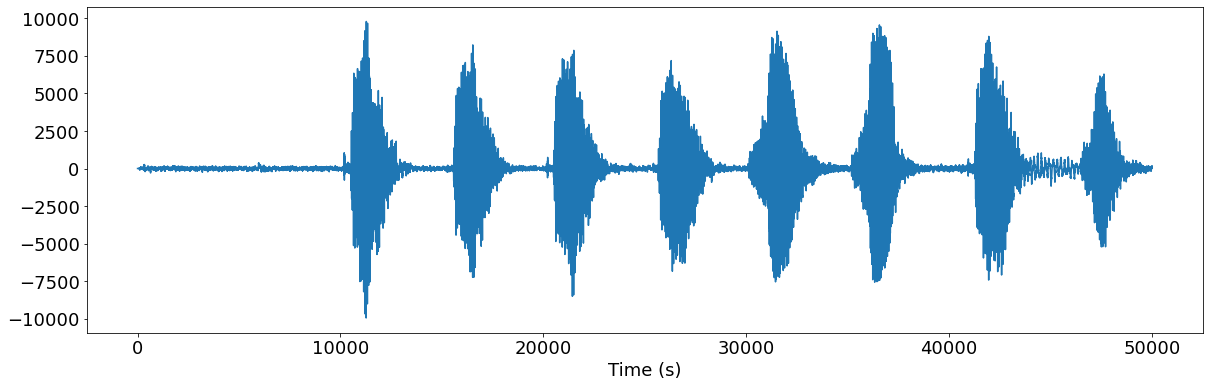

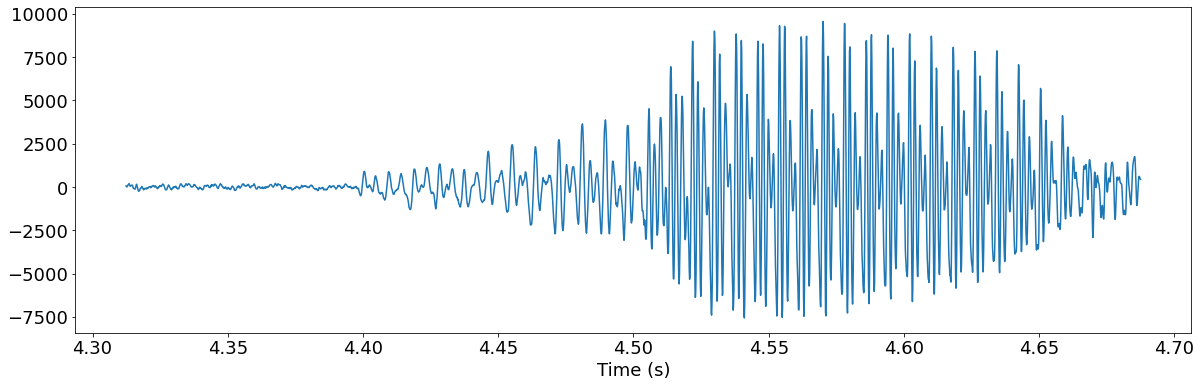

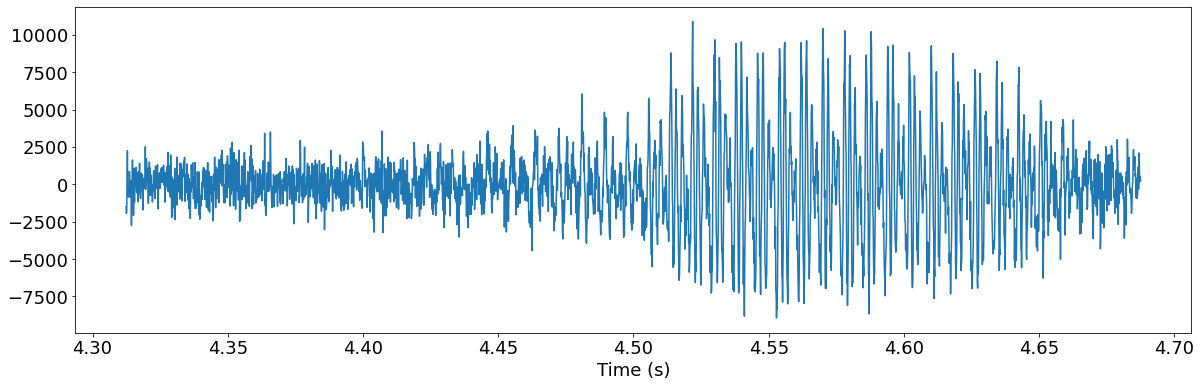

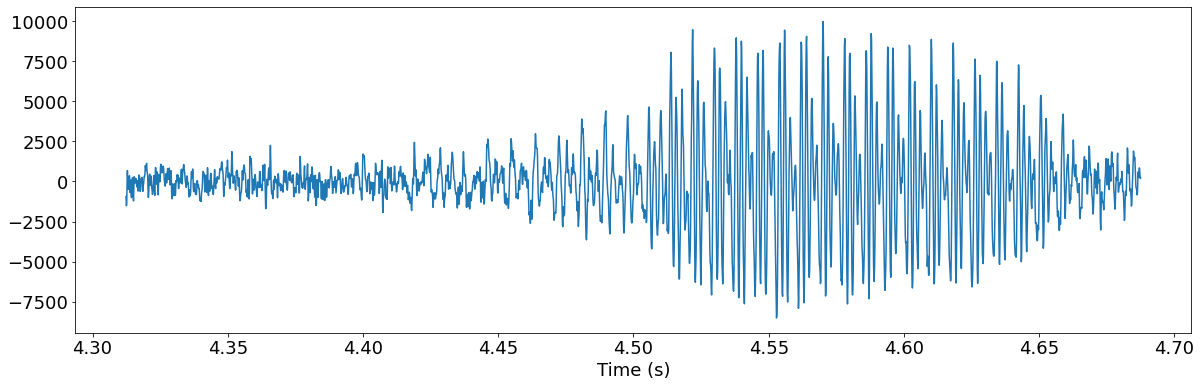

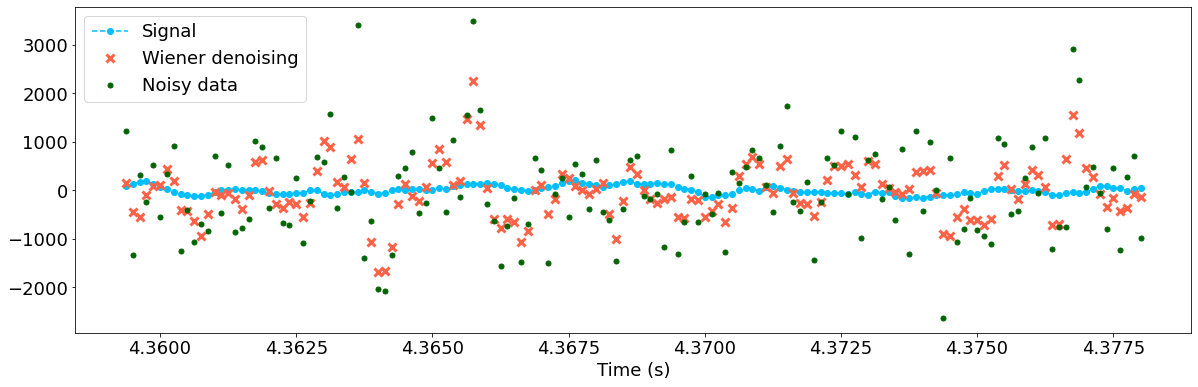

In [22]:
n_examples = 1
for ind,noise_std in enumerate(noise_std_array):
    print('='*50 +'\n\n')
    print('Noise Std: ', noise_std) 
    for i in range(n_examples):
        visualize_best_wiener_denoising(val_dataset[i], noise_std, wiener_star[noise_std], fs= val_fs_array[i], max_val = val_max_array[i], fft_sample=fft_sample,ind_fig=ind)

# STFT and Block STFT

In [23]:
def get_block_L2_norm(mat, window_size):
    
    kernel = np.ones([window_size, window_size]);

    out = signal.convolve2d(mat**2, kernel, boundary='fill', mode='same')
    
    return out

### Clean Signal log(Coefficient Magnitude) Histogram

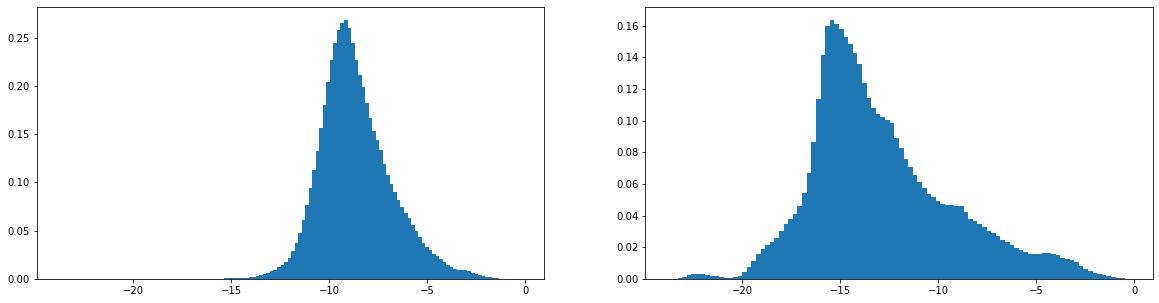

In [24]:
coeff_array = []
block_coeff_array = []

fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize = (20, 5));
for i in range(len(train_dataset)):
    temp = signal.stft(train_dataset[i], fs = train_fs_array[i], nperseg=nperseg)
    coeff_array += list(np.log(np.abs(temp[2])).reshape(-1))
    block_coeff_array += list(np.log( get_block_L2_norm(np.abs(temp[2]), window_size )).reshape(-1))
    
_ = axes[0].hist(coeff_array, bins = 100, density=True)
_ = axes[1].hist(block_coeff_array, bins = 100, density=True)

### Noisy Signal log(Coefficient Magnitude) Histogram

Noise Std:  0.1


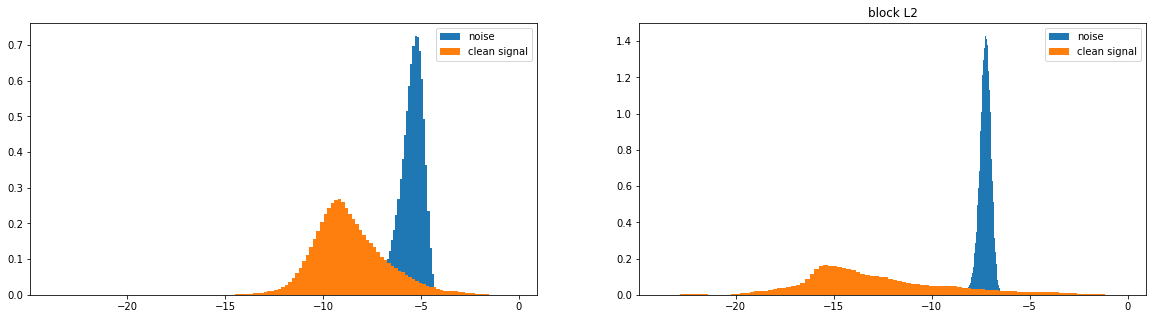

In [25]:
for noise_std in noise_std_array:
    noise_coeff_array = []
    noise_block_coeff_array = []
    for i in range(len(train_dataset)):
        temp = signal.stft( get_noise(train_dataset[i], noise_std=noise_std), fs = train_fs_array[i], nperseg=nperseg)
        noise_coeff_array += list(np.log(np.abs(temp[2])).reshape(-1))
        noise_block_coeff_array += list(np.log( get_block_L2_norm(np.abs(temp[2]), window_size )).reshape(-1))
        
    print('Noise Std: ', noise_std)
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize = (20, 5));
    _ = axes[0].hist(noise_coeff_array, bins = 100, density=True, label = 'noise')
    _ = axes[0].hist(coeff_array, bins = 100, density=True, label = 'clean signal')
    axes[0].legend()
    axes[1].set_title('coeff mag')
    
    _ = axes[1].hist(noise_block_coeff_array, bins = 100, density=True, label = 'noise')
    _ = axes[1].hist(block_coeff_array, bins = 100, density=True, label = 'clean signal')
    axes[1].set_title('block L2')
    axes[1].legend()
    
    plt.show()
    print('='*50 +'\n\n')

In [26]:
def stft_denoising(source, noise_std, fs, nperseg, thresh, window_size, block_thresh = None, noise_sample = None, plot_res = True,ind=0):
    
    if noise_sample is None:
        noisy = source + get_noise(source, noise_std);
    else:
        noisy = source + noise_sample
        
    if block_thresh is None:
        block_thresh = thresh;
        
    source_stft = signal.stft(source, fs = fs, nperseg=nperseg);
    noisy_stft = signal.stft(noisy, fs = fs, nperseg=nperseg);
    
    denoised_stft = deepcopy(noisy_stft);
    block_denoised_stft = deepcopy(noisy_stft);
    
    Zxx = noisy_stft[2];
    abs_Zxx_block_L2_norm = get_block_L2_norm(np.abs(Zxx), window_size);
    
    denoised_stft = list(denoised_stft)
    denoised_stft[2] = np.where(np.abs(Zxx) >= thresh, Zxx, 0);
    
    block_denoised_stft = list(block_denoised_stft)
    block_denoised_stft[2] = np.where(abs_Zxx_block_L2_norm >= block_thresh, Zxx, 0);
    
    if plot_res:
        plot_stft(source_stft,save_str='_clean_'+str(ind));
        plot_stft(noisy_stft,save_str='_noisy_'+str(ind));
        plot_stft(denoised_stft,save_str='_denoised_'+str(ind));
        plot_stft(block_denoised_stft,save_str='_block_denoised_'+str(ind));
    
    _, source_istft =  signal.istft(source_stft[2], fs=fs, nperseg=nperseg);
    _, noisy_istft =   signal.istft(noisy_stft[2], fs=fs, nperseg=nperseg);
    _, denoised_istft =   signal.istft(denoised_stft[2], fs=fs, nperseg=nperseg);
    _, block_denoised_istft =   signal.istft(block_denoised_stft[2], fs=fs, nperseg=nperseg);
    
    
    return np.real(source_istft), np.real(noisy_istft), np.real(denoised_istft), np.real(block_denoised_istft)
    
    

In [27]:
def plot_stft(stft_array,save_str=''):
    f, t, Zxx = stft_array;
    Zxx_abs = np.abs(Zxx)
    Zxx_abs[Zxx_abs<1e-5] = 1e-5
    plt.figure()
    plt.pcolormesh(t, f,Zxx_abs, norm=colors.LogNorm(vmin=Zxx_abs.min(), vmax=Zxx_abs.max()),cmap='jet' )
    # ax.set_title('log STFT Magnitude')
    tick_size = 18
    label_size = 18
    cb = plt.colorbar()
    plt.tick_params(labelsize=tick_size)
    cb.ax.tick_params(labelsize=tick_size)
    plt.ylabel('Frequency (Hz)',fontsize=label_size)
    plt.xlabel('Time (s)',fontsize=label_size)
    plt.show()

### Choosing Threshold Based on Train Error

In [28]:
threshold_array = [1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1e0, 1e2]

noise std:  0.1


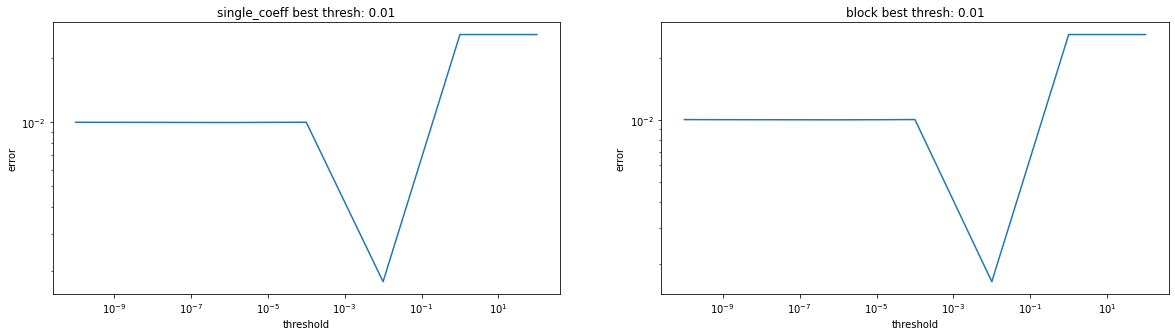

In [29]:
error_dict = {}
block_error_dict = {}
best_threshold_dict = {}
block_best_threshold_dict = {}
for noise_std in noise_std_array:
    
    error_dict[noise_std] = np.zeros_like(threshold_array);
    block_error_dict[noise_std] = np.zeros_like(threshold_array);
    
    for thresh_i, thresh in enumerate(threshold_array):
        total_error = 0.0;
        block_total_error = 0.0;
        total_length = 0.0;
        for i, x in enumerate(train_dataset):
            rec_source, rec_noisy, rec_denoised, rec_denoised_block = stft_denoising(x, noise_std, train_fs_array[i], nperseg, thresh, window_size,plot_res=False);
            total_error += np.linalg.norm( rec_denoised - rec_source)**2;
            block_total_error += np.linalg.norm( rec_denoised_block - rec_source)**2;
            total_length += len(rec_source);
            
        error_dict[noise_std][thresh_i] = (total_error/total_length);
        block_error_dict[noise_std][thresh_i] = (block_total_error/total_length);
        
    print('noise std: ', noise_std);
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize = (20, 5));
    
    axes[0].loglog(threshold_array, error_dict[noise_std])
    axes[0].set_xlabel('threshold')
    axes[0].set_ylabel('error')
        
    best_threshold_dict[noise_std] = threshold_array[np.argmin(error_dict[noise_std])]
    
    axes[0].set_title('single_coeff best thresh: '+str(best_threshold_dict[noise_std]))
    
    axes[1].loglog(threshold_array, block_error_dict[noise_std])
    axes[1].set_xlabel('threshold')
    axes[1].set_ylabel('error')
        
    block_best_threshold_dict[noise_std] = threshold_array[np.argmin(block_error_dict[noise_std])]
    
    axes[1].set_title('block best thresh: '+str(block_best_threshold_dict[noise_std]))
    
    plt.show()
    
    print('='*50+'\n')
        

### Comparison Between Wiener and STFT Threshold

In [30]:
val_idx = 2

source = val_dataset[val_idx]
fs = val_fs_array[val_idx]
max_val = val_max_array[val_idx]
# max_val = 1

In [31]:
figsize = (20, 6)
fig_size=(20,6)

Noise Std:  0.1
Source: 


Noisy: 


Wiener Denoised: 


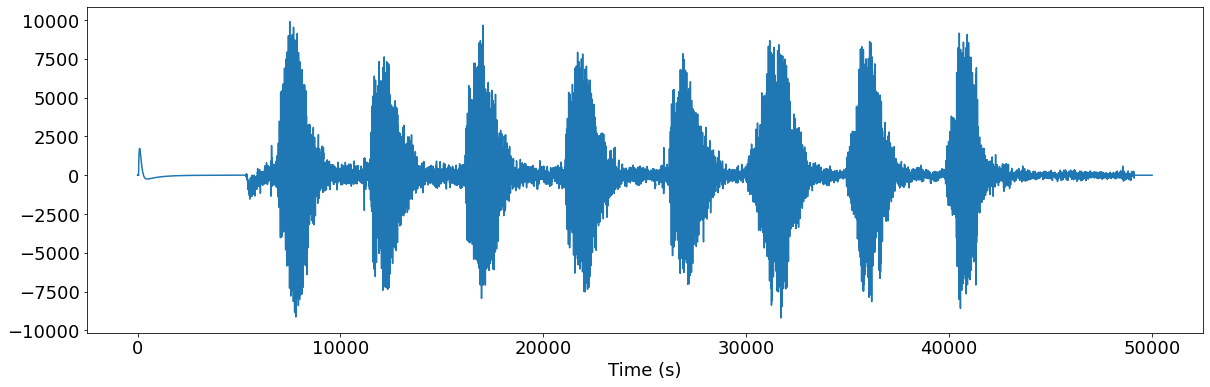

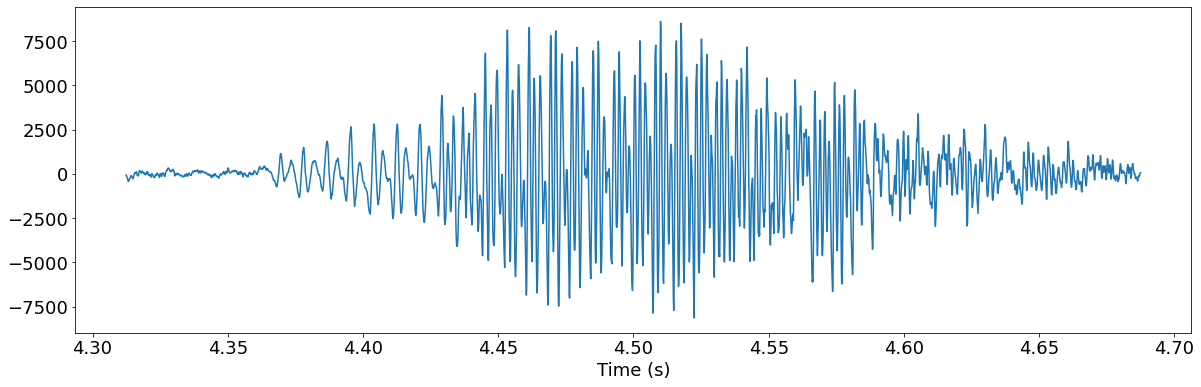

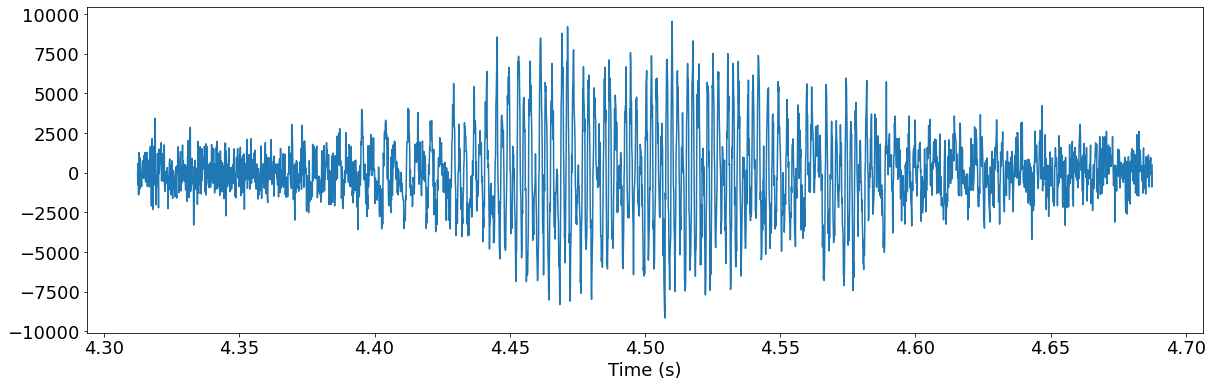

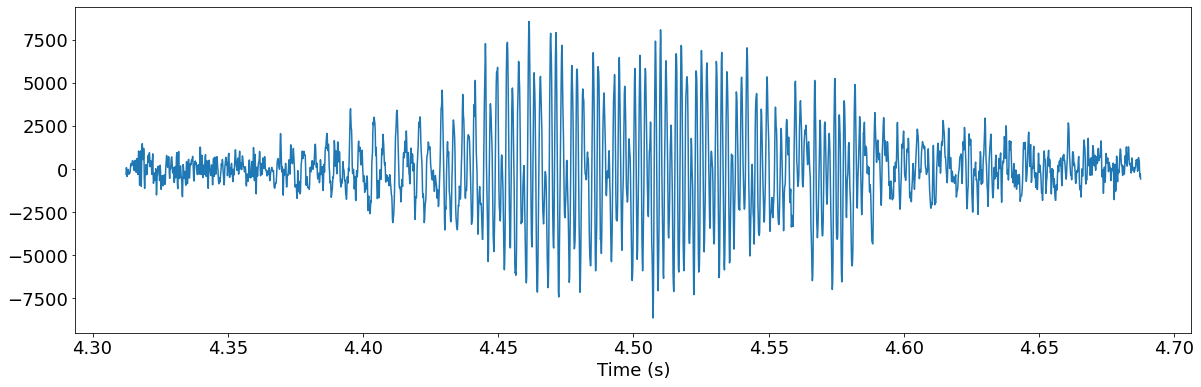

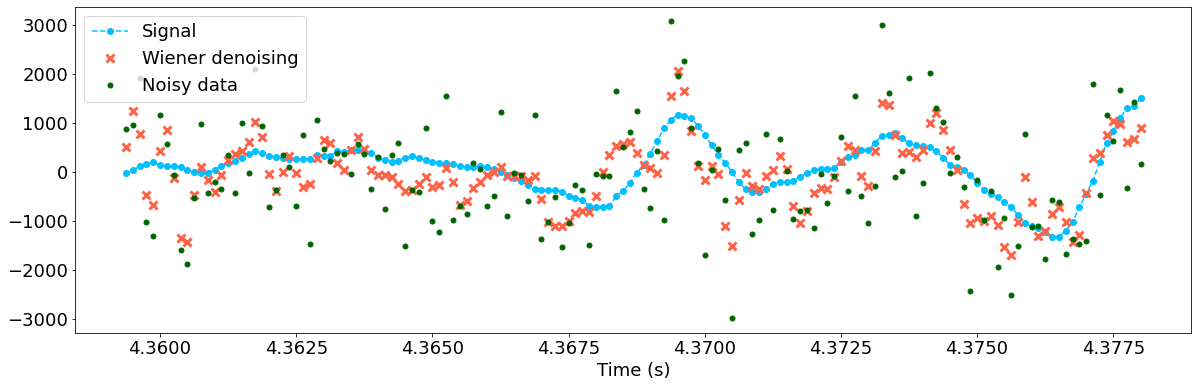

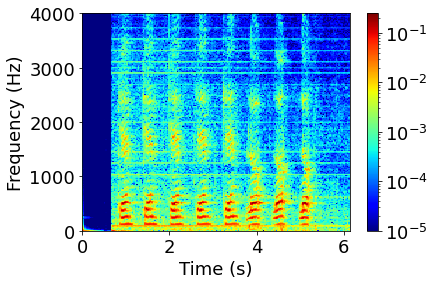

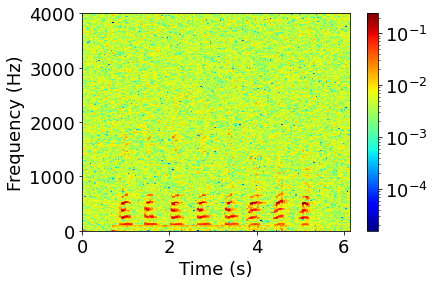

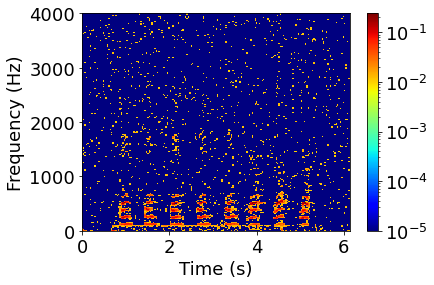

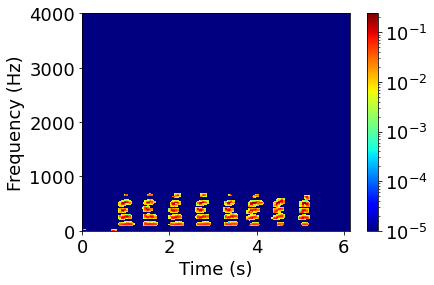

STFT Denoised: 


Block STFT Denoised: 


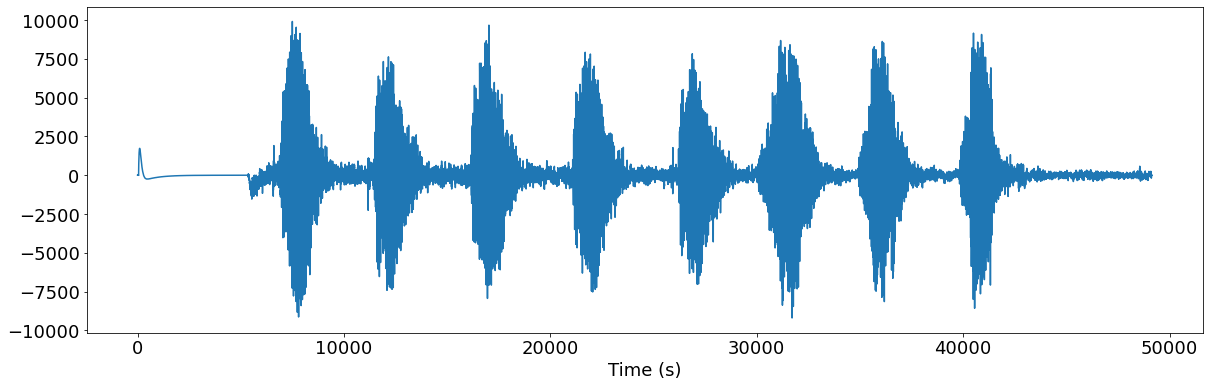

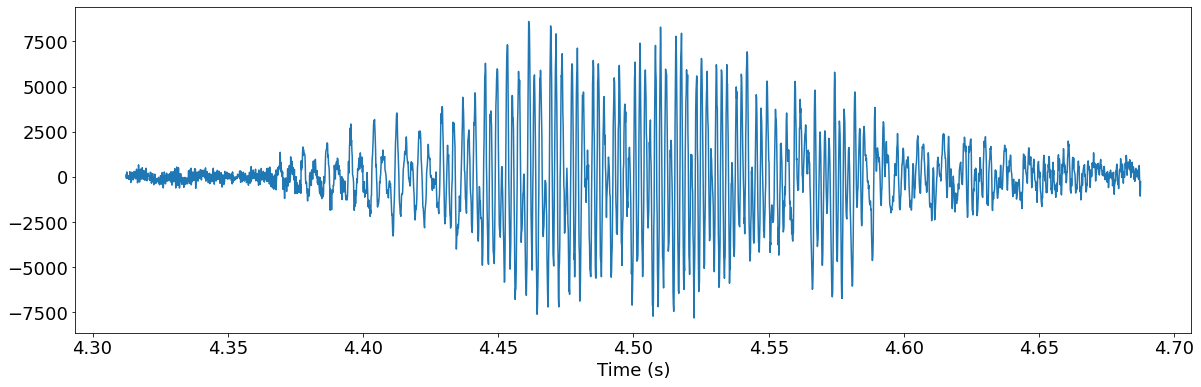

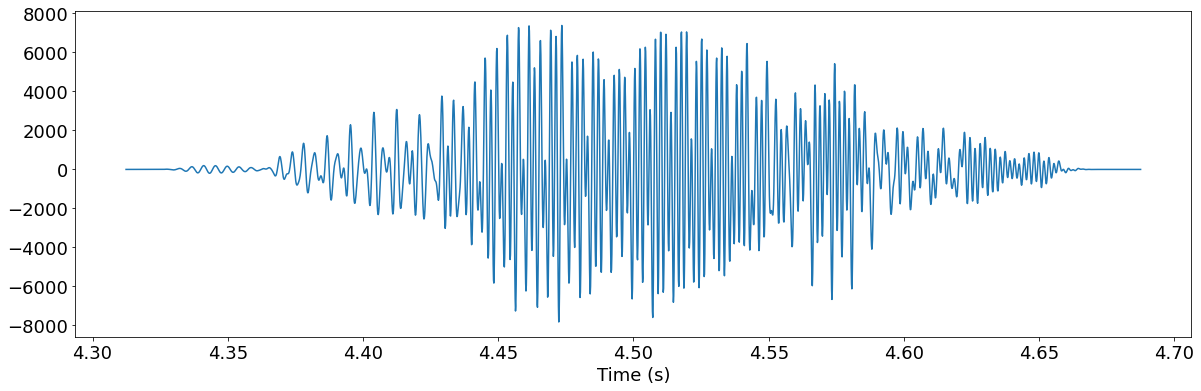

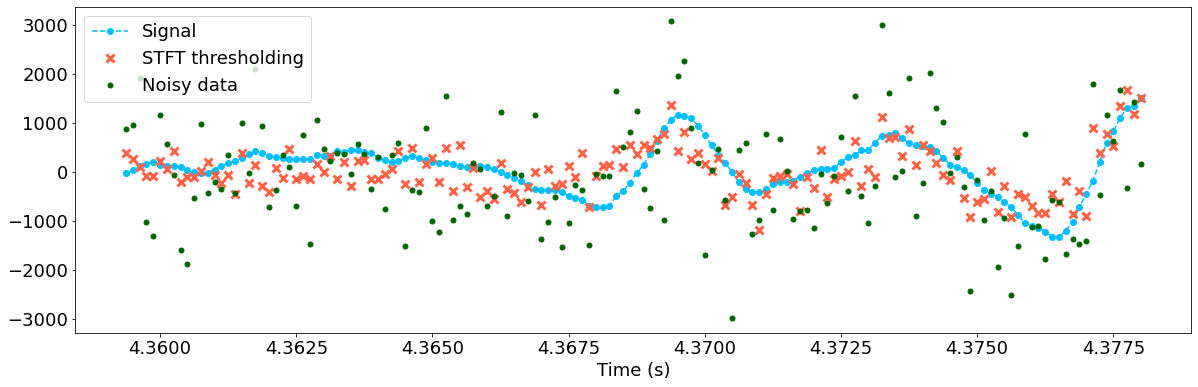

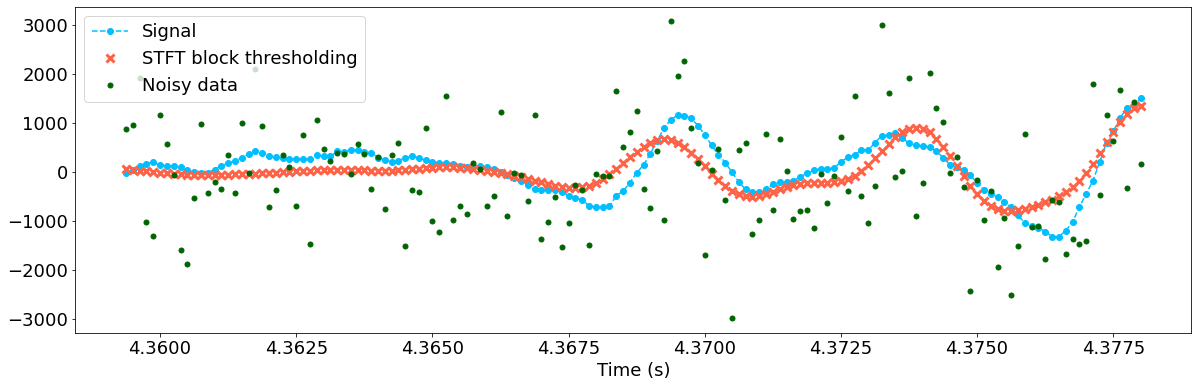

In [32]:
for ind_fig,noise_std in enumerate(noise_std_array):
    
    print('Noise Std: ', noise_std)
    
    noise_sample = get_noise(source, noise_std = noise_std);
    
    ifft_source = visualize_best_wiener_denoising(source, noise_std, wiener_star[noise_std], fs = fs, max_val =  max_val, fft_sample=fft_sample, noise_sample=noise_sample)
    
    istft_source, istft_noisy, istft_denoised, istft_denoised_block = stft_denoising(source, noise_std, fs, nperseg,
                                                               thresh = best_threshold_dict[noise_std], 
                                                               window_size = window_size,
                                                               block_thresh = block_best_threshold_dict[noise_std], 
                                                               noise_sample=noise_sample)
    istft_denoised_block *= max_val
    istft_denoised *= max_val;
    istft_noisy *= max_val;
    istft_source *= max_val;
    
    print('STFT Denoised: ')
    IPython.display.display(ipd.Audio(istft_denoised, rate=fs))
    
    print('Block STFT Denoised: ')
    IPython.display.display(ipd.Audio(istft_denoised_block, rate=fs))
    
    label_size = 18
    font_size = 18
    
    t_indices = np.arange(len(istft_source))/fs
    
    plt.figure(figsize = fig_size)
    plt.plot(np.real(istft_source))
    plt.xlabel('Time (s)',fontsize=font_size)
    plt.tick_params(labelsize=label_size)
    
    plt.figure(figsize = fig_size)
    plt.plot(t_indices[ini:end],np.real(istft_denoised[ini:end]))
    plt.xlabel('Time (s)',fontsize=font_size)
    plt.tick_params(labelsize=label_size)

    
    plt.figure(figsize = fig_size)
    plt.plot(t_indices[ini:end],np.real(istft_denoised_block[ini:end]))
    plt.xlabel('Time (s)',fontsize=font_size)
    plt.tick_params(labelsize=label_size)



   
    plt.figure(figsize = fig_size)
    plt.plot(t_indices[ini2:end2],np.real(istft_source[ini2:end2]),'--o',markersize=6,lw=1.5,color='deepskyblue', label='Signal')
    plt.plot(t_indices[ini2:end2],np.real(istft_denoised[ini2:end2]),'x',color='tomato',markersize=8,mew=3, label='STFT thresholding')
    plt.plot(t_indices[ini2:end2],np.real(istft_noisy[ini2:end2]),'.',color='darkgreen',markersize=10,label='Noisy data')
    plt.xlabel('Time (s)',fontsize=font_size)
    # plt.ylim([-12e3,12e3])
    plt.tick_params(labelsize=label_size)
    plt.legend(fontsize=font_size)

    
    plt.figure(figsize = fig_size)
    plt.plot(t_indices[ini2:end2],np.real(istft_source[ini2:end2]),'--o',markersize=6,lw=1.5,color='deepskyblue', label='Signal')
    plt.plot(t_indices[ini2:end2],np.real(istft_denoised_block[ini2:end2]),'x',color='tomato',markersize=8,mew=3, label='STFT block thresholding')
    plt.plot(t_indices[ini2:end2],np.real(istft_noisy[ini2:end2]),'.',color='darkgreen',markersize=10,label='Noisy data')
    plt.xlabel('Time (s)',fontsize=font_size)
    # plt.ylim([-12e3,12e3])
    plt.tick_params(labelsize=label_size)
    plt.legend(fontsize=font_size)

    
    plt.show()
 
    
    print('='*50 + '\n')